## 07 행렬 분해를 이용한 잠재 요인 협업 필터링 실습

- 행렬 분해 잠재 요인 협업 필터링은 SVD나 NMF 등을 적용할 수 있음.
- SVD가 자줒 사요오디지만 사용자-아이템 평점 행렬에는 사용자가 평점을 매기지 않은 널 데이터가 많기 떄문에 주로 SGD나 ALS 기반의 행렬 분해 이용


In [ ]:
# get_rmse() 함수 그대로 사용해 행렬 분해 로직을 새로운 matrix_factorziation() 함수로 정의
# k는 잠재 요인 차원의 수, steps는 SGD의 반복횟수, learning_rate는 학습률, r_lambda는 L2 규제 계수
import numpy as np
from sklearn.metrics import mean_squared_error

def get_rmse(R, P, Q, non_zeros):
    error = 0
    # 두개의 분해된 행렬 P와 Q.T의 내적 곱으로 예측 R 행렬 생성
    full_pred_matrix = np.dot(P, Q.T)

    # 실제 R 행렬에서 널이 아닌 값의 위치 인덱스 추출하여 실제 R 행렬과 예측 행렬의 RMSE 추출
    x_non_zero_ind = [non_zero[0] for non_zero in non_zeros]
    y_non_zero_ind = [non_zero[1] for non_zero in non_zeros]
    R_non_zeros = R[x_non_zero_ind, y_non_zero_ind]

    full_pred_matrix_non_zeros = full_pred_matrix[x_non_zero_ind, y_non_zero_ind]

    mse = mean_squared_error(R_non_zeros, full_pred_matrix_non_zeros)
    rmse = np.sqrt(mse)

    return rmse

In [ ]:
def matrix_factorization(R, K, steps=200, learning_rate=0.01, r_lambda = 0.01):
    num_users, num_items = R.shape
    # P와 Q 매트릭스의 크기를 지정하고 정규분포를 가진 랜덤한 값으로 입력합니다.
    np.random.seed(1)
    P = np.random.normal(scale=1./K, size=(num_users, K))
    Q = np.random.normal(scale=1./K, size=(num_items, K))

    # R > 0 인 행 위치, 열 위치, 값을 non_zeros 리스트 객체에 저장.
    non_zeros = [ (i, j, R[i,j]) for i in range(num_users) for j in range(num_items) if R[i,j] > 0 ]

    # SGD기법으로 P와 Q 매트릭스를 계속 업데이트.
    for step in range(steps):
        for i, j, r in non_zeros:
            # 실제 값과 예측 값의 차이인 오류 값 구함
            eij = r - np.dot(P[i, :], Q[j, :].T)
            # Regularization을 반영한 SGD 업데이트 공식 적용
            P[i,:] = P[i,:] + learning_rate*(eij * Q[j, :] - r_lambda*P[i,:])
            Q[j,:] = Q[j,:] + learning_rate*(eij * P[i, :] - r_lambda*Q[j,:])

        rmse = get_rmse(R, P, Q, non_zeros)
        if (step % 10) == 0 :
            print("### iteration step : ", step," rmse : ", rmse)

    return P, Q

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving movies.csv to movies.csv
Saving ratings.csv to ratings.csv


In [ ]:
# 영화 평점 행렬 데이터를 DataFrame으로 로딩한 뒤에 다시 사용자-아이템 평점 행렬로 만들기
import numpy as np
import pandas as pd

movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')
ratings = ratings[['userId', 'movieId', 'rating']]
ratings_matrix = ratings.pivot_table('rating', index='userId', columns='movieId')

# title 컬럼을 얻기 이해 movies 와 조인 수행
rating_movies = pd.merge(ratings, movies, on='movieId')

# columns='title' 로 title 컬럼으로 pivot 수행.
ratings_matrix = rating_movies.pivot_table('rating', index='userId', columns='title')


In [ ]:
# 다시 만들어진 사용자-아이템 평점 행렬을 matrix_factorization() 함수를 이용해 행렬 분해
P, Q = matrix_factorization(ratings_matrix.values, K=50, steps=200, learning_rate=0.01, r_lambda = 0.01)
pred_matrix = np.dot(P, Q.T)

### iteration step :  0  rmse :  2.9023619751336867
### iteration step :  10  rmse :  0.7335768591017927
### iteration step :  20  rmse :  0.5115539026853442
### iteration step :  30  rmse :  0.37261628282537446
### iteration step :  40  rmse :  0.2960818299181014
### iteration step :  50  rmse :  0.2520353192341642
### iteration step :  60  rmse :  0.22487503275269854
### iteration step :  70  rmse :  0.2068545530233154
### iteration step :  80  rmse :  0.19413418783028685
### iteration step :  90  rmse :  0.18470082002720406
### iteration step :  100  rmse :  0.17742927527209104
### iteration step :  110  rmse :  0.1716522696470749
### iteration step :  120  rmse :  0.16695181946871726
### iteration step :  130  rmse :  0.16305292191997542
### iteration step :  140  rmse :  0.15976691929679646
### iteration step :  150  rmse :  0.1569598699945732
### iteration step :  160  rmse :  0.15453398186715425
### iteration step :  170  rmse :  0.15241618551077643
### iteration step :  180  rm

In [ ]:
ratings_pred_matrix = pd.DataFrame(data=pred_matrix, index=ratings_matrix.index, columns= ratings_matrix.columns)
ratings_pred_matrix.head(3)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,3.055084,4.092018,3.564130,4.502167,3.981215,1.271694,3.603274,2.333266,5.091749,3.972454,...,1.402608,4.208382,3.705957,2.720514,2.787331,3.475076,3.253458,2.161087,4.010495,0.859474
2,3.170119,3.657992,3.308707,4.166521,4.311890,1.275469,4.237972,1.900366,3.392859,3.647421,...,0.973811,3.528264,3.361532,2.672535,2.404456,4.232789,2.911602,1.634576,4.135735,0.725684
3,2.307073,1.658853,1.443538,2.208859,2.229486,0.780760,1.997043,0.924908,2.970700,2.551446,...,0.520354,1.709494,2.281596,1.782833,1.635173,1.323276,2.887580,1.042618,2.293890,0.396941


In [ ]:
def get_unseen_movies(ratings_matrix, userId):
    # userId로 입력받은 사용자의 모든 영화정보 추출하여 Series로 반환함.
    # 반환된 user_rating 은 영화명(title)을 index로 가지는 Series 객체임.
    user_rating = ratings_matrix.loc[userId,:]

    # user_rating이 0보다 크면 기존에 관람한 영화임. 대상 index를 추출하여 list 객체로 만듬
    already_seen = user_rating[ user_rating > 0].index.tolist()

    # 모든 영화명을 list 객체로 만듬.
    movies_list = ratings_matrix.columns.tolist()

    # list comprehension으로 already_seen에 해당하는 movie는 movies_list에서 제외함.
    unseen_list = [ movie for movie in movies_list if movie not in already_seen]

    return unseen_list


In [ ]:
def recomm_movie_by_userid(pred_df, userId, unseen_list, top_n=10):
    # 예측 평점 DataFrame에서 사용자id index와 unseen_list로 들어온 영화명 컬럼을 추출하여
    # 가장 예측 평점이 높은 순으로 정렬함.
    recomm_movies = pred_df.loc[userId, unseen_list].sort_values(ascending=False)[:top_n]
    return recomm_movies

In [ ]:
# 사용자가 관람하지 않은 영화명 추출
unseen_list = get_unseen_movies(ratings_matrix, 9)

# 잠재 요인 협업 필터링으로 영화 추천
recomm_movies = recomm_movie_by_userid(ratings_pred_matrix, 9, unseen_list, top_n=10)

# 평점 데이터를 DataFrame 으로 생성
recomm_movies = pd.DataFrame(data=recomm_movies.values, index=recomm_movies.index, columns=['pred_scores'])
recomm_movies

,pred_scores
title,
Rear Window (1954),5.704612
"South Park: Bigger, Longer and Uncut (1999)",5.451100
Rounders (1998),5.298393
Blade Runner (1982),5.244951
Roger & Me (1989),5.191962
Gattaca (1997),5.183179
Ben-Hur (1959),5.130463
Rosencrantz and Guildenstern Are Dead (1990),5.087375
"Big Lebowski, The (1998)",5.038690


---
## 08 파이썬 추천 시스템 패키지 - Surprise
- 파이썬 기반에서 사아킷런과 유사한 api와 프레임 워크 제공

In [ ]:
!pip install numpy==1.23.5
!pip install scikit-surprise --no-binary :all:

In [ ]:
from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split

In [ ]:
data = Dataset.load_builtin('ml-100k')
# 수행 시마다 동일하게 데이터를 분할하기 위해 random_state 값 부여
trainset, testset = train_test_split(data, test_size=.25, random_state=0)

Dataset ml-100k could not be found. Do you want to download it? [Y/n] ㅛ
Dataset ml-100k could not be found. Do you want to download it? [Y/n] y
Trying to download dataset from https://files.grouplens.org/datasets/movielens/ml-100k.zip...
Done! Dataset ml-100k has been saved to /root/.surprise_data/ml-100k


In [ ]:
# SVD로 협업 필터링 수행
algo = SVD(random_state=0)
algo.fit(trainset)

In [ ]:
predictions = algo.test(testset)
print('prediction type :', type(predictions), 'size:', len(predictions))
print('prediction 결과의 최초 5개 추출')
predictions[:5]

prediction type : <class 'list'> size: 25000
prediction 결과의 최초 5개 추출


[Prediction(uid='120', iid='282', r_ui=4.0, est=3.5114147666251547, details={'was_impossible': False}),
 Prediction(uid='882', iid='291', r_ui=4.0, est=3.573872419581491, details={'was_impossible': False}),
 Prediction(uid='535', iid='507', r_ui=5.0, est=4.033583485472447, details={'was_impossible': False}),
 Prediction(uid='697', iid='244', r_ui=5.0, est=3.8463639495936905, details={'was_impossible': False}),
 Prediction(uid='751', iid='385', r_ui=4.0, est=3.1807542478219157, details={'was_impossible': False})]

In [ ]:
[ (pred.uid, pred.iid, pred.est) for pred in predictions[:3] ]

[('120', '282', 3.5114147666251547),
 ('882', '291', 3.573872419581491),
 ('535', '507', 4.033583485472447)]

In [ ]:
# 사용자 아이다, 아이템 아이디는 문자열로 입력해야 함
uid = str(196)
iid = str(302)
pred = algo.predict(uid, iid)
print(pred)

user: 196        item: 302        r_ui = None   est = 4.49   {'was_impossible': False}


In [ ]:
accuracy.rmse(predictions)

RMSE: 0.9467


0.9466860806937948

### Surprise 주요 모듈 소개
- 사용자 아이디, 아이템 아이디, 평점 데이터가 로우 레벨로 된 데이터 세트만 적용 가능
- 예를 들어, 첫번 째는 사용자 아이디, 두번쨰 칼럼은 아이템 아이지, 세번 쨰 칼럼은 평점으로 가정해 데이터를 로딩하고 네번째 칼럼부터는 로딩을 수행하지 않음.

In [ ]:
# OS 파일 데이터를 Surprise 데이터 세트로 로딩
import pandas as pd

ratings = pd.read_csv('ratings.csv')
# ratings_noh.csv 파일로 업로드 시 인덱스와 헤더를 모두 제거한 새로운 파일 생성.
ratings.to_csv('ratings_noh.csv', index=False, header=False)

- reader 클래스를 이용해 데이터 파일의 파싱 포맷을 정의, 로딩될 ratings_noh.csv 파일의 파싱 정보를 알려주기 위해 사용
- reader 클래스의 생성자에 각 필드의 칼럼명과 칼럼 분리 문자 그리고 최소~최대 평점을 입력해 객체를 생성

In [ ]:
from surprise import Reader

reader = Reader(line_format = 'user item rating timestamp', sep=',', rating_scale=(0.5, 5))
data = Dataset.load_from_file('ratings_noh.csv', reader=reader)

- line_format(string): 칼럼을 순서대로 나열, 입력된 문자열을 공백으로 분리해 칼럼으로 인식
- sep (char): 칼럼을 분리하는 분리자이며, 디폴트는 '\t'임. 판다스 DataFrame에서 입력받을 경우 기재할 필요 x
- rating_scale (tuple, optional): 평점 값의 최소~최대 평점을 설정, 디폴트는 (1,5)이지만 ratings.csv 파일의 경우 최소 평점이 0.5, 최대 평점이 5이므로 (0.5,5) 설정

In [ ]:
trainset, testset = train_test_split(data, test_size=.25, random_state=0)

# 수행 시마다 동일한 결과를 도출하기 위해 random_state 설정
algo = SVD(n_factors = 50, random_state=0)

# 학습 데이터 세트로 학습하고 나서 텍스트 데이터 세트로 평점 예측 후 RMSE 평가
algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions)

RMSE: 0.8682


0.8681952927143516

### 판다스 DataFrame에서 Surprise 데이터 세트로 로딩

In [ ]:
import pandas as pd
from surprise import Reader, Dataset

ratings = pd.read_csv('ratings.csv')
reader = Reader(rating_scale=(0.5, 5.0))

ratings = ratings.rename(columns={
    '1': 'userId',
    '1.1': 'movieId',
    '4.0': 'rating'
})


# ratings DataFrame 에서 컬럼은 사용자 아이디, 아이템 아이디, 평점 순서를 지켜야 합니다.
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=.25, random_state=0)

algo = SVD(n_factors=50, random_state=0)
algo.fit(trainset)
predictions = algo.test( testset )
accuracy.rmse(predictions)

RMSE: 0.8682


0.8681952927143516

## Surprise 추천 알고리즘 클래스
- SVD, KNNBasic, Baselineonly(사용자 bias와 아이템 bias를 감안한 SGD 베이스라인 알고리즘)

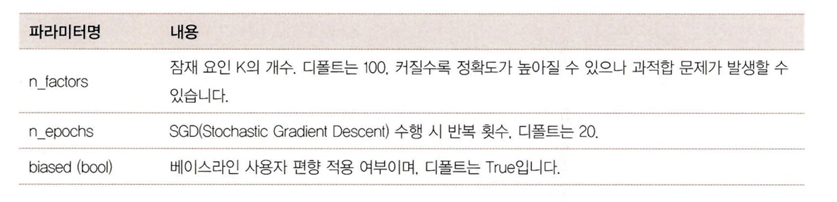

### 베이스라인 평점
- 개인의 성향을 반영해 아이템 평가에 편향성 요소를 반영해 평점을 부과하는 것
- 베이스라인 평점 = 전체 평균 평점 + 사용자 편향 점수 + 아이템 편향 점수 공식

### 교차 검증과 하이처 파라미터 튜닝
- cross_validate()와 GridSearchCV 클래스를 제공

In [ ]:
from surprise.model_selection import cross_validate

# 판다스 DataFrame에서 Surprise 데이터 세트로 데이터 로딩

ratings = pd.read_csv('ratings.csv')
reader = Reader(rating_scale=(0.5, 5.0))

ratings = ratings.rename(columns={
    '1': 'userId',
    '1.1': 'movieId',
    '4.0': 'rating'
})

data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

algo = SVD(random_state=0)
cross_validate(algo, data, measures = ['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8644  0.8832  0.8734  0.8827  0.8712  0.8750  0.0072  
MAE (testset)     0.6656  0.6795  0.6722  0.6778  0.6682  0.6726  0.0054  
Fit time          1.88    2.54    1.86    1.78    1.68    1.95    0.31    
Test time         0.13    0.27    0.24    0.30    0.11    0.21    0.08    


{'test_rmse': array([0.86435878, 0.88319034, 0.87338987, 0.88273151, 0.8712049 ]),
 'test_mae': array([0.66558451, 0.67948014, 0.6721729 , 0.67783753, 0.66815717]),
 'fit_time': (1.8782627582550049,
  2.544616460800171,
  1.864159345626831,
  1.7807106971740723,
  1.6813158988952637),
 'test_time': (0.12599444389343262,
  0.2719888687133789,
  0.24201011657714844,
  0.298384428024292,
  0.11341452598571777)}

In [ ]:
from surprise.model_selection import GridSearchCV

# 최적화할 파라미터를 딕셔너리 형태로 지정
param_grid = {'n_epochs' : [20,40,60], 'n_factors':[50,100,200]}

# CV를 3개 폴드 세트로 지정, 성능 평가는 rmse, mse 로 수행하도록 GridSearchCV 구성
gs = GridSearchCV(SVD, param_grid, measures = ['rmse', 'mae'], cv=3)
gs.fit(data)

# 최고 RMSE Evaluation 점수와 그때의 하이퍼 파라미터
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

0.876827952328289
{'n_epochs': 20, 'n_factors': 50}


### surprise를 이용한 개인화 영화 추천 시스템 구축

In [ ]:
# 다음 코드는 train_test_split()으로 분리되지 않는 데이터 세트에 fit()을 호출해 오류가 발생

data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
algo = SVD(n_factors=50, random_state=0)
# algo.fit(data)

In [ ]:
from surprise.dataset import DatasetAutoFolds

reader = Reader(line_format = 'user item rating timestamp', sep=',', rating_scale=(0.5, 5))
# DatasetAutoFolds 클래스를 ratings_noh.csv 파일 기반으로 생성
data_folds = DatasetAutoFolds(ratings_file = 'ratings_noh.csv', reader= reader)

# 전체 데이터를 학습 데이터로 생성함
trainset = data_folds.build_full_trainset()

In [ ]:
algo = SVD(n_epochs=20, n_factors=50, random_state=0)
algo.fit(trainset)

In [ ]:
# 영화에 대한 상세 속성 정보 DataFrame 로딩
movies = pd.read_csv('movies.csv')

# userId = 9의 movieId 데이터를 추출해 movieId=42 데이터가 있는지 확인
movieIds = ratings[ratings['userId']==9]['movieId']

if movieIds[movieIds == 42].count() == 0:
    print('사용자 아이디 9는 영화 아이디 42의 평점 없음')

print(movies[movies['movieId']==42])

사용자 아이디 9는 영화 아이디 42의 평점 없음
    movieId                   title              genres
38       42  Dead Presidents (1995)  Action|Crime|Drama


In [ ]:
uid = str(9)
iid = str(42)

In [ ]:
def get_unseen_surprise(ratings, movies, userId):
    # 입력값으로 들어온 userId에 해당하는 사용자가 평점을 매긴 모든 영화를 리스트로 생성
    seen_movies = ratings[ratings['userId']==userId]['movieId'].tolist()

    # 모든 영화의 movieid를 리스트로 생성
    total_movies = movies['movieId'].tolist()

    # 모든 영화의 movieId 중 이미 평점을 매긴 영화의 movieId를 제외한 후 리스트로 생성
    unseen_movies = [movie for movie in total_movies if movie not in seen_movies]
    print('평점 매긴 영화 수:', len(seen_movies), '추천 대상 영화 수:', len(unseen_movies), '전체 영화 수:', len(total_movies))

    return unseen_movies

unseen_movies = get_unseen_surprise(ratings, movies, 9)

평점 매긴 영화 수: 46 추천 대상 영화 수: 9696 전체 영화 수: 9742


In [ ]:
def recomm_movie_by_surprise(algo, userId, unseen_movies, top_n=10):
    # 알고리즘 객체의 predict() 메서드를 평점이 없는 영화에 반복 수행한 후 결과를 list 객체로 저장
    predictions = [algo.predict(str(userId), str(movieId)) for movieId in unseen_movies]

    # predictions list 객체는 surprise의 Predictions 객체를 원소로 가지고 있음.
    # [Prediction(uid='9', iid='1', est=3.69), Prediction(uid='9', iid='2', est=2.98),,,,]
    # 이를 est 값으로 정렬하기 위해서 아래의 sortkey_est 함수를 정의함.
    # sortkey_est 함수는 list 객체의 sort() 함수의 키 값으로 사용되어 정렬 수행.
    def sortkey_est(pred):
        return pred.est

    # sortkey_est( ) 반환값의 내림 차순으로 정렬 수행하고 top_n개의 최상위 값 추출.
    predictions.sort(key=sortkey_est, reverse=True)
    top_predictions= predictions[:top_n]

    # top_n으로 추출된 영화의 정보 추출. 영화 아이디, 추천 예상 평점, 제목 추출
    top_movie_ids = [ int(pred.iid) for pred in top_predictions]
    top_movie_rating = [ pred.est for pred in top_predictions]
    top_movie_titles = movies[movies.movieId.isin(top_movie_ids)]['title']
    top_movie_preds = [ (id, title, rating) for id, title, rating in zip(top_movie_ids, top_movie_titles, top_movie_rating)]

    return top_movie_preds

In [ ]:
unseen_movies = get_unseen_surprise(ratings, movies, 9)
top_movie_preds = recomm_movie_by_surprise(algo, 9, unseen_movies, top_n=10)
print('##### Top-10 추천 영화 리스트 #####')

for top_movie in top_movie_preds:
    print(top_movie[1], ":", top_movie[2])

평점 매긴 영화 수: 46 추천 대상 영화 수: 9696 전체 영화 수: 9742
##### Top-10 추천 영화 리스트 #####
Usual Suspects, The (1995) : 4.306302135700814
Star Wars: Episode IV - A New Hope (1977) : 4.281663842987387
Pulp Fiction (1994) : 4.278152632122759
Silence of the Lambs, The (1991) : 4.226073566460876
Godfather, The (1972) : 4.1918097904381995
Streetcar Named Desire, A (1951) : 4.154746591122657
Star Wars: Episode V - The Empire Strikes Back (1980) : 4.122016128534504
Star Wars: Episode VI - Return of the Jedi (1983) : 4.108009609093436
Goodfellas (1990) : 4.083464936588478
Glory (1989) : 4.07887165526957


## 09 정리
- 추천 시스템은 기업 애플리케이션에서 매우 중요한 위치 차지
- 콘텐츠 기반 필터링과 협업 필터링 살펴좀
- 협업 필터링은 최근접 이웃 협업 필터링과 잠재 요인 협업 필터링 나뉨.
- 잠재 요인 협업 필터링은 사용자-아잍메 평점 행렬 데이터에 숨어 있는 잠재 요인을 추출하여 사용하여 사용자가 아직 평점을 매기지 않은 아이템에 대한 평점을 예측하여 이를 추천에 반영
- 파이썬의 추천 패키지 surprise 간단한 api만을 이용해 파이썬 기반에서 추천시스템 구현